In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'

In [34]:
def phi_finite(kx, ky, F2, l):
    k = np.sqrt(kx * kx + ky * ky)
    pressure = 2. * F2 * np.sin(kx / (2 * F2)) / kx
    pressure[kx == 0] = 1
    return k * pressure / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.01, kmax=128, d=0.125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_finite(k[:, None], k[None, :], \
                             np.power(F, 2.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [3]:
phase = -1.7

def draw_wake_plot(ax, x, phi, bound=None, scale=False):
    r = x[-1]
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
        avg = np.average(phi)
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound)
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian',
                         vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian')
    return img

def draw_kelvin_angle(ax, x, f=1000, color='blue'):
    y = np.sqrt(x**2.0/8.)
    ax.plot(x, y, color=color, linestyle=':')

def draw_inner_angle(ax, x, T, color='black'):
    slope = np.sqrt(T - 1.) / (2. * T - 1.)
    y = slope * x
    ax.plot(x, -y, color=color, linestyle=':')
    
def draw_parametric_wake(ax, nmax, t, color='black', phase=phase):
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        ax.plot(xt, -yt, color=color, linestyle=':', linewidth=1)

def calc_T_value(f, a=1):
    return a * f * f * f * f

In [4]:
def create_large_figure(fig, xvals, phis, froudes, nrows, ncols, bounds=None, scale=False,
                        kelvin=False, inner=False, parametric=False, xshift=0, xfull=False,
                        xbounds=None, ybounds=None, a=1):
    if xbounds is None and ybounds is None:
        try:
            xbounds = [xvals[0, 0], xvals[0, -1] if xfull else 0]
            ybounds = [xvals[0, 0]/2, xvals[0, -1]/2]
        except:
            xbounds = [xvals[0][0], xvals[0][-1] if xfull else 0]
            ybounds = [xvals[0][0]/2, xvals[0][-1]/2]
        xbounds = xbounds - xbounds[0] * xshift
    label = 'a'
    
    for r in range(nrows):
        for c in range(ncols):
            i = r * ncols + c
            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.set_xlim(xbounds)
            ax.set_ylim(ybounds)
            ax.text(0.97, 0.97, 'F=%.2f' % froudes[i], 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='top')
            ax.text(0.97, 0.03, label, 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
            label = chr(ord(label) + 1)
            if bounds is None:
                bound = None
            elif type(bounds) == list:
                bound = bounds[i]
            else:
                bound = bounds
            
            img = draw_wake_plot(ax, xvals[i], phis[i], bound=bound, scale=scale)
            xs = xvals[i][xvals[i] <= 0]
            if kelvin:                    
                draw_kelvin_angle(ax, xs)
            if inner:
                draw_inner_angle(ax, xs, calc_T_value(froudes[i], a=a), color='black')
            if parametric:
                t = np.linspace(1, calc_T_value(froudes[i], a=a), 10000)
                draw_parametric_wake(ax, 4, t, color='black')
            if c == 0:
                ax.set_ylabel('Y')
            else:
                nlbls = len(ax.get_yticklabels())
                ax.set_yticklabels([''] * nlbls)
            if r == nrows - 1:
                ax.set_xlabel('X')
            else:
                nlbls = len(ax.get_xticklabels())
                ax.set_xticklabels([''] * nlbls)

In [66]:
zerFs = [0.1, 0.2, 0.3, 0.4, 0.5]
vsmFs = [0.6, 0.65, 0.7, 0.75, 0.8]
tr1Fs = [0.66, 0.68, 0.7, 0.72, 0.74]
tr2Fs = [0.76, 0.78, 0.8, 0.82, 0.84]
tr3Fs = [0.83, 0.86, 0.89, 0.92, 0.95]
smlFs = [0.86, 0.9, 0.94, 0.98, 1.0]
medFs = [1.02, 1.06, 1.1, 1.15, 1.2]
morFs = [1.5, 1.75, 2.0, 2.5, 3.0]
lrgFs = [1.6, 2, 5, 8, 12]

vsmKmax = 128
smlKmax = 128
medKmax = 128
morKmax = 256
lrgKmax = 256
delta = 1. / 8.

def generate_wake_patterns(fvals, kmax, delta):
    xs = []
    phis = []
    for f in fvals:
        x, p = calculate_wake(f, kmax=kmax, d=delta)
        xs.append(np.real(x))
        phis.append(np.real(p))
        print('F = %f done' % f)
    
    return xs, phis

In [68]:
zerXs, zerPs = generate_wake_patterns(zerFs, vsmKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 0.100000 done
F = 0.200000 done
F = 0.300000 done
F = 0.400000 done
F = 0.500000 done


In [35]:
vsmXs, vsmPs = generate_wake_patterns(vsmFs, vsmKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 0.600000 done
F = 0.650000 done
F = 0.700000 done
F = 0.750000 done
F = 0.800000 done


In [36]:
tr1Xs, tr1Ps = generate_wake_patterns(tr1Fs, vsmKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 0.660000 done
F = 0.680000 done
F = 0.700000 done
F = 0.720000 done
F = 0.740000 done


In [37]:
tr2Xs, tr2Ps = generate_wake_patterns(tr2Fs, vsmKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 0.760000 done
F = 0.780000 done
F = 0.800000 done
F = 0.820000 done
F = 0.840000 done


In [38]:
tr3Xs, tr3Ps = generate_wake_patterns(tr3Fs, vsmKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 0.830000 done
F = 0.860000 done
F = 0.890000 done
F = 0.920000 done
F = 0.950000 done


In [39]:
smlXs, smlPs = generate_wake_patterns(smlFs, smlKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 0.860000 done
F = 0.900000 done
F = 0.940000 done
F = 0.980000 done
F = 1.000000 done


In [40]:
medXs, medPs = generate_wake_patterns(medFs, medKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 1.020000 done
F = 1.060000 done
F = 1.100000 done
F = 1.150000 done
F = 1.200000 done


In [41]:
morXs, morPs = generate_wake_patterns(morFs, morKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 1.500000 done
F = 1.750000 done
F = 2.000000 done
F = 2.500000 done
F = 3.000000 done


In [42]:
lrgXs, lrgPs = generate_wake_patterns(lrgFs, lrgKmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


F = 1.600000 done
F = 2.000000 done
F = 5.000000 done
F = 8.000000 done
F = 12.000000 done


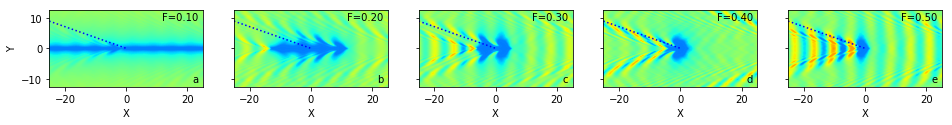

In [77]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, zerXs, zerPs, zerFs,
                    #1, 5, scale=False,
                    1, 5, scale=True, bounds=3, xfull=True,
                    kelvin=True, inner=False, parametric=False)

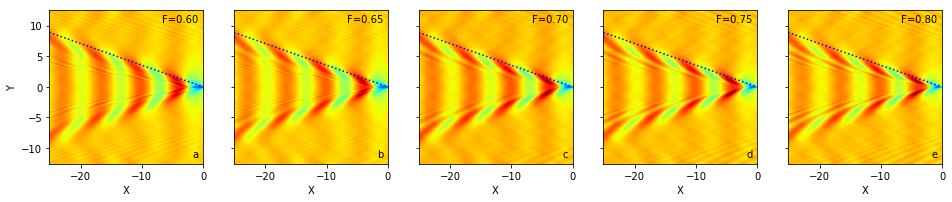

In [65]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, vsmXs, vsmPs, vsmFs,
                    #1, 5, scale=False,
                    1, 5, scale=True, bounds=3,
                    kelvin=True, inner=False, parametric=False)

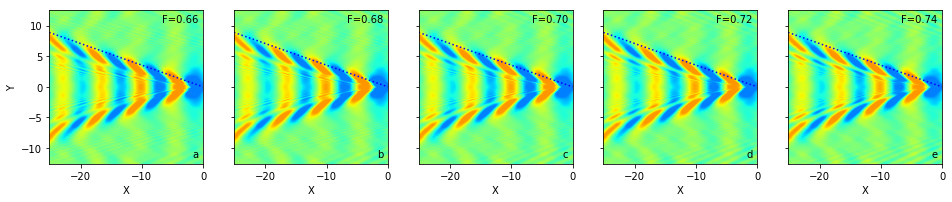

In [59]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, tr1Xs, tr1Ps, tr1Fs,
                    #1, 5, scale=False,
                    1, 5, scale=True, bounds=3,
                    kelvin=True, inner=False, parametric=False)

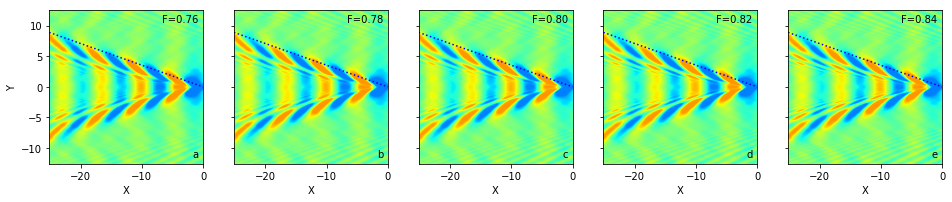

In [60]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, tr2Xs, tr2Ps, tr2Fs,
                    1, 5, scale=True, bounds=3,
                    kelvin=True, inner=False, parametric=False)

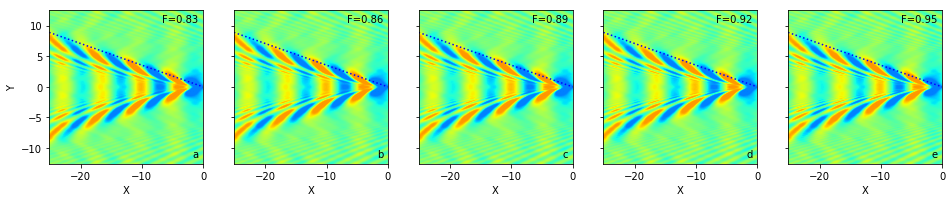

In [46]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, tr3Xs, tr3Ps, tr3Fs,
                    1, 5, 
                    #scale=False,
                    scale=True, bounds=3,
                    kelvin=True, inner=False, parametric=False, a=2)

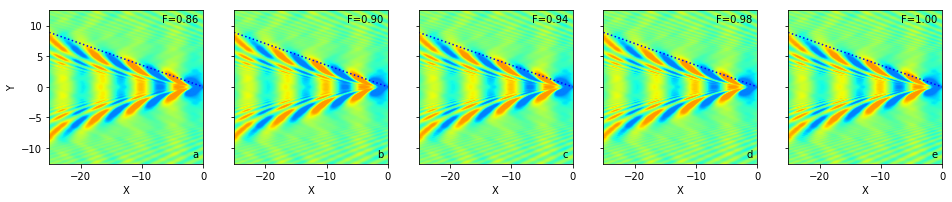

In [61]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, smlXs, smlPs, smlFs,
                    #1, 5, scale=False,
                    1, 5, scale=True, bounds=3,
                    kelvin=True, inner=False, parametric=False, a=2)

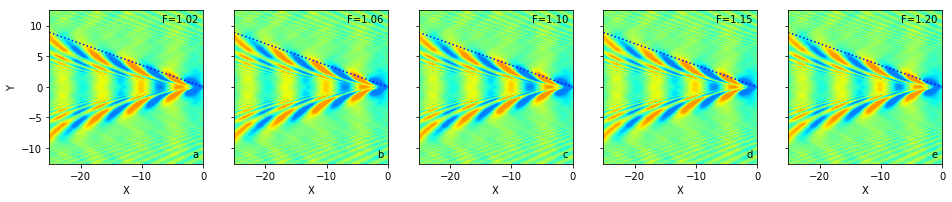

In [62]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, medXs, medPs, medFs,
                    #1, 5, scale=False,
                    1, 5, scale=True, bounds=3,
                    kelvin=True, inner=False, parametric=False, a=2)

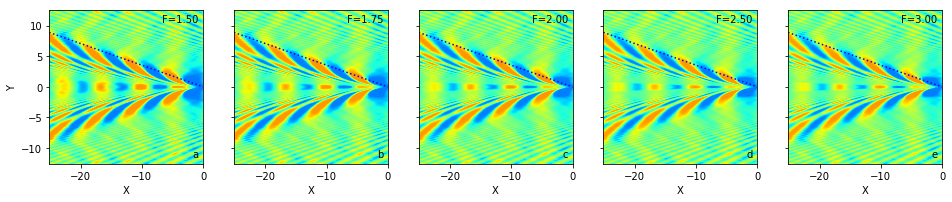

In [63]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, morXs, morPs, morFs,
                    1, 5, scale=True, bounds=[1.5, 1.5, 1.5, 1.5, 1.5],
                    #1, 5, scale=False,
                    kelvin=True, inner=False, parametric=False, a=2)

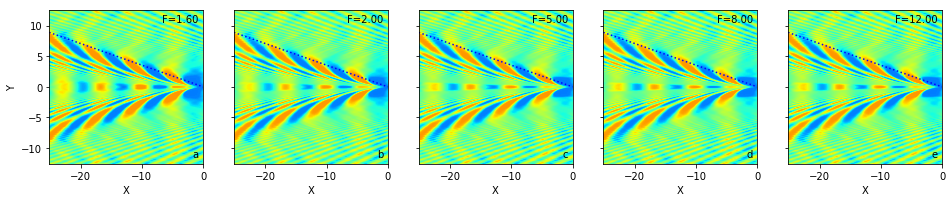

In [64]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, lrgXs, lrgPs, lrgFs,
                    1, 5, scale=True, bounds=[1.5, 1.5, 1.25, 1.25, 1.25],
                    kelvin=True, inner=False, parametric=False, a=2)